## Постановка задачи

**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

course_project_train.csv - обучающий датасет<br>
course_project_test.csv - тестовый датасет

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

**Подключение библиотек и скриптов**

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

**Пути к директориям и файлам**

In [6]:
TRAIN_DATASET_PATH = './course_project_train.csv'
TEST_DATASET_PATH = './course_project_test.csv'
PREP_DATASET_PATH = './train_prep.csv'
PROBA_DATASET_PATH = './NNesterenko_predictions.csv'

SCALER_FILE_PATH = './scaler.pkl'

TRAIN_FULL_PATH = './training_project_train_full.csv'
TRAIN_PART_PATH = './training_project_train_part_b.csv'
TEST_PART_PATH = './training_project_test_part.csv'

### Загрузка данных

In [7]:
# Тренировочный датасет
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [8]:
# Сравним тренировочный датасет с тестовым
df_test = pd.read_csv(TEST_DATASET_PATH)
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [9]:
df_train.shape

(7500, 17)

In [10]:
df_test.shape

(2500, 16)

In [11]:
# Посмотрим общую информацию.
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
Home Ownership                  7500 non-null object
Annual Income                   5943 non-null float64
Years in current job            7129 non-null object
Tax Liens                       7500 non-null float64
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null float64
Months since last delinquent    3419 non-null float64
Bankruptcies                    7486 non-null float64
Purpose                         7500 non-null object
Term                            7500 non-null object
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Score                    5943 non-null float64
Credit Default                  7

In [12]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
Home Ownership                  2500 non-null object
Annual Income                   1987 non-null float64
Years in current job            2414 non-null object
Tax Liens                       2500 non-null float64
Number of Open Accounts         2500 non-null float64
Years of Credit History         2500 non-null float64
Maximum Open Credit             2500 non-null float64
Number of Credit Problems       2500 non-null float64
Months since last delinquent    1142 non-null float64
Bankruptcies                    2497 non-null float64
Purpose                         2500 non-null object
Term                            2500 non-null object
Current Loan Amount             2500 non-null float64
Current Credit Balance          2500 non-null float64
Monthly Debt                    2500 non-null float64
Credit Score                    1987 non-null float64
dtypes: float64(12), object(4)
me

Данные совпадают. Пропуски одни и те же.

### Обработка пропусков и выбросов

**Имеются пропуски. Исследуем их**

In [13]:
# Annual Income
print('Наименьшее: ', df_train['Annual Income'].min())
print('Наибольшее: ', df_train['Annual Income'].max())
print('Медиана: ', df_train['Annual Income'].median())
print('Среднее: ', df_train['Annual Income'].mean())
print('Мода: ', df_train['Annual Income'].mode()[0])

Наименьшее:  164597.0
Наибольшее:  10149344.0
Медиана:  1168386.0
Среднее:  1366391.7201749957
Мода:  969475.0


In [14]:
# На первый взгляд в Annual Income нет выбросов. Мы не можем с достаточной уверенностью заявлять,
# что какой то доход не реальный. Для замены пропусков в доходе, на мой взгляд болше подойдет
# медиана.

In [15]:
# Заменим пропуски на медиану
df_train.loc[df_train['Annual Income'].isnull(), 'Annual Income'] = df_train['Annual Income'].median()

In [16]:
# Сменим тип данных
df_train['Annual Income'] = df_train['Annual Income'].astype(int)

In [17]:
# Months since last delinquent
print('Наименьшее: ', df_train['Months since last delinquent'].min())
print('Наибольшее: ', df_train['Months since last delinquent'].max())
print('Медиана: ', df_train['Months since last delinquent'].median())
print('Среднее: ', df_train['Months since last delinquent'].mean())
print('Мода: ', df_train['Months since last delinquent'].mode()[0])

Наименьшее:  0.0
Наибольшее:  118.0
Медиана:  32.0
Среднее:  34.69260017548991
Мода:  14.0


In [18]:
# Здесь так же сложно утверждать, что какое либо значение является выбросом. Пропуски целесообразнее заменить
# наиболее часто встречающимся значением. Вероятность такого события наибольшая.

In [19]:
# Заменим пропуски на moda
df_train.loc[df_train['Months since last delinquent'].isnull(), 'Months since last delinquent'] = df_train['Months since last delinquent'].mode()[0]

In [20]:
# Сменим тип данных
df_train['Months since last delinquent'] = df_train['Months since last delinquent'].astype(int)

In [21]:
# Credit Score
print('Наименьшее: ', df_train['Credit Score'].min())
print('Наибольшее: ', df_train['Credit Score'].max())
print('Медиана: ', df_train['Credit Score'].median())
print('Среднее: ', df_train['Credit Score'].mean())
print('Мода: ', df_train['Credit Score'].mode()[0])

Наименьшее:  585.0
Наибольшее:  7510.0
Медиана:  731.0
Среднее:  1151.0874978966851
Мода:  740.0


In [22]:
# Скорее всего в данных имеются выбросы. Сделаем предположение, что кредитный рейтинг должен быть
# трехзначным. Разделим четырехзначные значения на 10.

In [23]:
df_train.loc[df_train['Credit Score'] / 1000 > 1, 'Credit Score'] = df_train['Credit Score'] / 10

In [24]:
# Можно заметить, что явного преобладания какого либо рейтинга нет. Можно предположить, что люди без рейтинга
# не брали кредит и не имеют рейтинга. При отсутствии рейтинга у трети заемщиков, использование этого показателя
# вызывает сомнения. Пока заменим пустые значения 0.

In [25]:
# Заменим пропуски на 0
df_train.loc[df_train['Credit Score'].isnull(), 'Credit Score'] = 0

In [26]:
# Сменим тип данных
df_train['Credit Score'] = df_train['Credit Score'].astype(int)

In [27]:
df_train['Credit Score'].value_counts()

0      1557
740     184
747     172
748     163
745     155
       ... 
630       1
631       1
619       1
607       1
586       1
Name: Credit Score, Length: 161, dtype: int64

In [28]:
df_train['Bankruptcies'].value_counts()

0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

In [29]:
# Заменим пропуски на moda
df_train.loc[df_train['Bankruptcies'].isnull(), 'Bankruptcies'] = df_train['Bankruptcies'].mode()[0]

In [30]:
# Сменим тип данных
df_train['Bankruptcies'] = df_train['Bankruptcies'].astype(int)

In [31]:
df_train['Years in current job'].value_counts()

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

In [32]:
# Заменим str на int. Переведем категорийные данные в численные.
def replacement(df):    
    df.loc[df['Years in current job'] == '10+ years', 'Years in current job'] = 10
    df.loc[df['Years in current job'] == '< 1 year', 'Years in current job'] = 0
    df.loc[df['Years in current job'] == '1 year', 'Years in current job'] = 1
    # Заменим пропуски на 10, как наиболее часто встречающееся
    df.loc[df['Years in current job'].isnull(), 'Years in current job'] = 10
    for n in range(2, 10):
        df.loc[df['Years in current job'] == str(n)+' years', 'Years in current job'] = n  

In [33]:
replacement(df_train)

In [34]:
df_train['Years in current job'].value_counts()

10    2703
2      705
3      620
0      563
5      516
1      504
4      469
6      426
7      396
8      339
9      259
Name: Years in current job, dtype: int64

In [35]:
# Сохраним промежуточные значения
BASE_DATASET_PATH = './NNesterenko_base_dataset.csv'
df_train.to_csv(BASE_DATASET_PATH, index=False, encoding='utf-8')

**Обзор номинативных признаков**

In [36]:
for cat_colname in df_train.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df_train[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64
****************************************************************************************************

Term

Short Term    5556
Long Term     1944
Name: Term, dtype: int64
****************************************************************************************************



In [37]:
# Объединим для Purpose все значения, кроме debt consolidation  в other, поскольку их количество незначительно.
df_train.loc[df_train['Purpose'] != 'debt consolidation', 'Purpose'] = 'other'

In [38]:
df_train['Purpose'].value_counts()

debt consolidation    5944
other                 1556
Name: Purpose, dtype: int64

### Приведение типов

In [39]:
# Переведем float в int
for colname in ['Number of Open Accounts', 'Number of Credit Problems', 'Years of Credit History',
                'Tax Liens', 'Maximum Open Credit', 'Current Loan Amount', 'Current Credit Balance',
               'Monthly Debt']:
    df_train[colname] = df_train[colname].astype(int)

In [40]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
Home Ownership                  7500 non-null object
Annual Income                   7500 non-null int64
Years in current job            7500 non-null int64
Tax Liens                       7500 non-null int64
Number of Open Accounts         7500 non-null int64
Years of Credit History         7500 non-null int64
Maximum Open Credit             7500 non-null int64
Number of Credit Problems       7500 non-null int64
Months since last delinquent    7500 non-null int64
Bankruptcies                    7500 non-null int64
Purpose                         7500 non-null object
Term                            7500 non-null object
Current Loan Amount             7500 non-null int64
Current Credit Balance          7500 non-null int64
Monthly Debt                    7500 non-null int64
Credit Score                    7500 non-null int64
Credit Default                  7500 non-null int64
dtypes

In [41]:
# Заменим в Term Long Term на 1 и Short Term на 0 и тип на int
df_train['Term'] = (df_train['Term'] == 'Long Term').astype(int)
df_train['Term'].value_counts()

0    5556
1    1944
Name: Term, dtype: int64

In [42]:
# Заменим в Purpose debt consolidation на 1 и other на 0 и тип на int
df_train['Purpose'] = (df_train['Purpose'] == 'debt consolidation').astype(int)
df_train['Purpose'].value_counts()

1    5944
0    1556
Name: Purpose, dtype: int64

### Построение новых признаков

**Id**

In [43]:
df_train['ID'] = df_train.index.tolist()

**Dummies**

In [44]:
for cat_colname in df_train.select_dtypes(include='object').columns[:]:
    df_train = pd.concat([df_train, pd.get_dummies(df_train[cat_colname], prefix=cat_colname)], axis=1)

In [45]:
# Удалим признак из которого сделаны dummies
df_train = df_train.drop('Home Ownership', axis=1)

In [46]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 21 columns):
Annual Income                   7500 non-null int64
Years in current job            7500 non-null int64
Tax Liens                       7500 non-null int64
Number of Open Accounts         7500 non-null int64
Years of Credit History         7500 non-null int64
Maximum Open Credit             7500 non-null int64
Number of Credit Problems       7500 non-null int64
Months since last delinquent    7500 non-null int64
Bankruptcies                    7500 non-null int64
Purpose                         7500 non-null int64
Term                            7500 non-null int64
Current Loan Amount             7500 non-null int64
Current Credit Balance          7500 non-null int64
Monthly Debt                    7500 non-null int64
Credit Score                    7500 non-null int64
Credit Default                  7500 non-null int64
ID                              7500 non-null int64
Home Owne

**Сохраним полученный датасет**

In [47]:
df_train.to_csv(PREP_DATASET_PATH, index=False, encoding='utf-8')

### Анализ данных

**Выделение целевой переменной и групп признаков**

In [48]:
df_base = pd.read_csv(BASE_DATASET_PATH)
df_train = pd.read_csv(PREP_DATASET_PATH)

In [49]:
df_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
Home Ownership                  7500 non-null object
Annual Income                   7500 non-null int64
Years in current job            7500 non-null int64
Tax Liens                       7500 non-null float64
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null float64
Months since last delinquent    7500 non-null int64
Bankruptcies                    7500 non-null int64
Purpose                         7500 non-null object
Term                            7500 non-null object
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Score                    7500 non-null int64
Credit Default                  7500 non-n

In [50]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 21 columns):
Annual Income                   7500 non-null int64
Years in current job            7500 non-null int64
Tax Liens                       7500 non-null int64
Number of Open Accounts         7500 non-null int64
Years of Credit History         7500 non-null int64
Maximum Open Credit             7500 non-null int64
Number of Credit Problems       7500 non-null int64
Months since last delinquent    7500 non-null int64
Bankruptcies                    7500 non-null int64
Purpose                         7500 non-null int64
Term                            7500 non-null int64
Current Loan Amount             7500 non-null int64
Current Credit Balance          7500 non-null int64
Monthly Debt                    7500 non-null int64
Credit Score                    7500 non-null int64
Credit Default                  7500 non-null int64
ID                              7500 non-null int64
Home Owne

In [51]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df_base.columns.drop(TARGET_NAME).tolist()

In [52]:
BASE_FEATURE_NAMES

['Home Ownership',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']

In [53]:
NEW_FEATURE_NAMES = df_train.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES[1:])
NEW_FEATURE_NAMES

Index(['ID', 'Home Ownership_Have Mortgage', 'Home Ownership_Home Mortgage',
       'Home Ownership_Own Home', 'Home Ownership_Rent'],
      dtype='object')

**Обзор целевой переменной**

In [54]:
df_train[TARGET_NAME].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

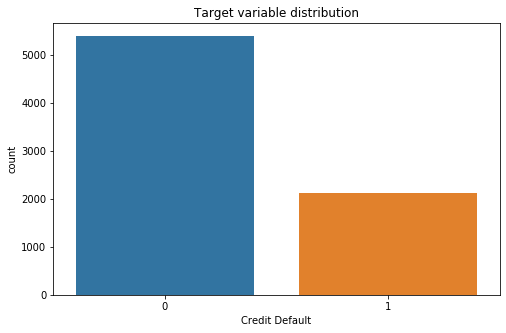

In [55]:
plt.figure(figsize=(8, 5))

sns.countplot(x=TARGET_NAME, data=df_train)

plt.title('Target variable distribution')
plt.show()

Целевая переменная существенно разбалансирована

**Корреляция с базовыми признаками**

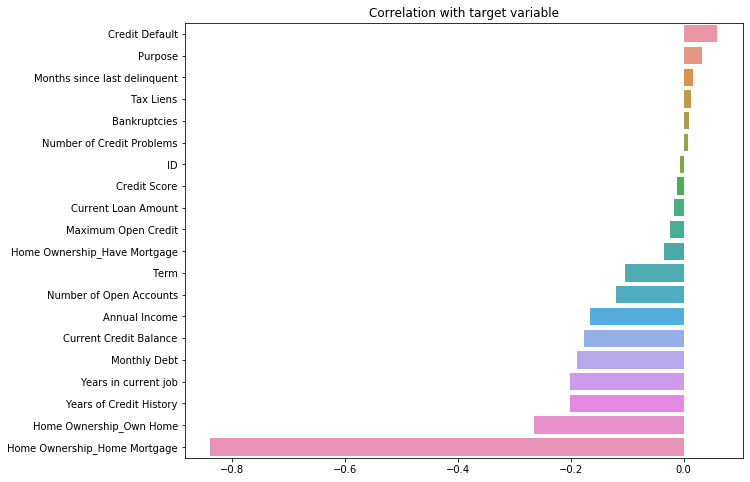

In [56]:
corr_with_target = df_train.corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

### Анализ признакового пространства

**Матрица корреляций**

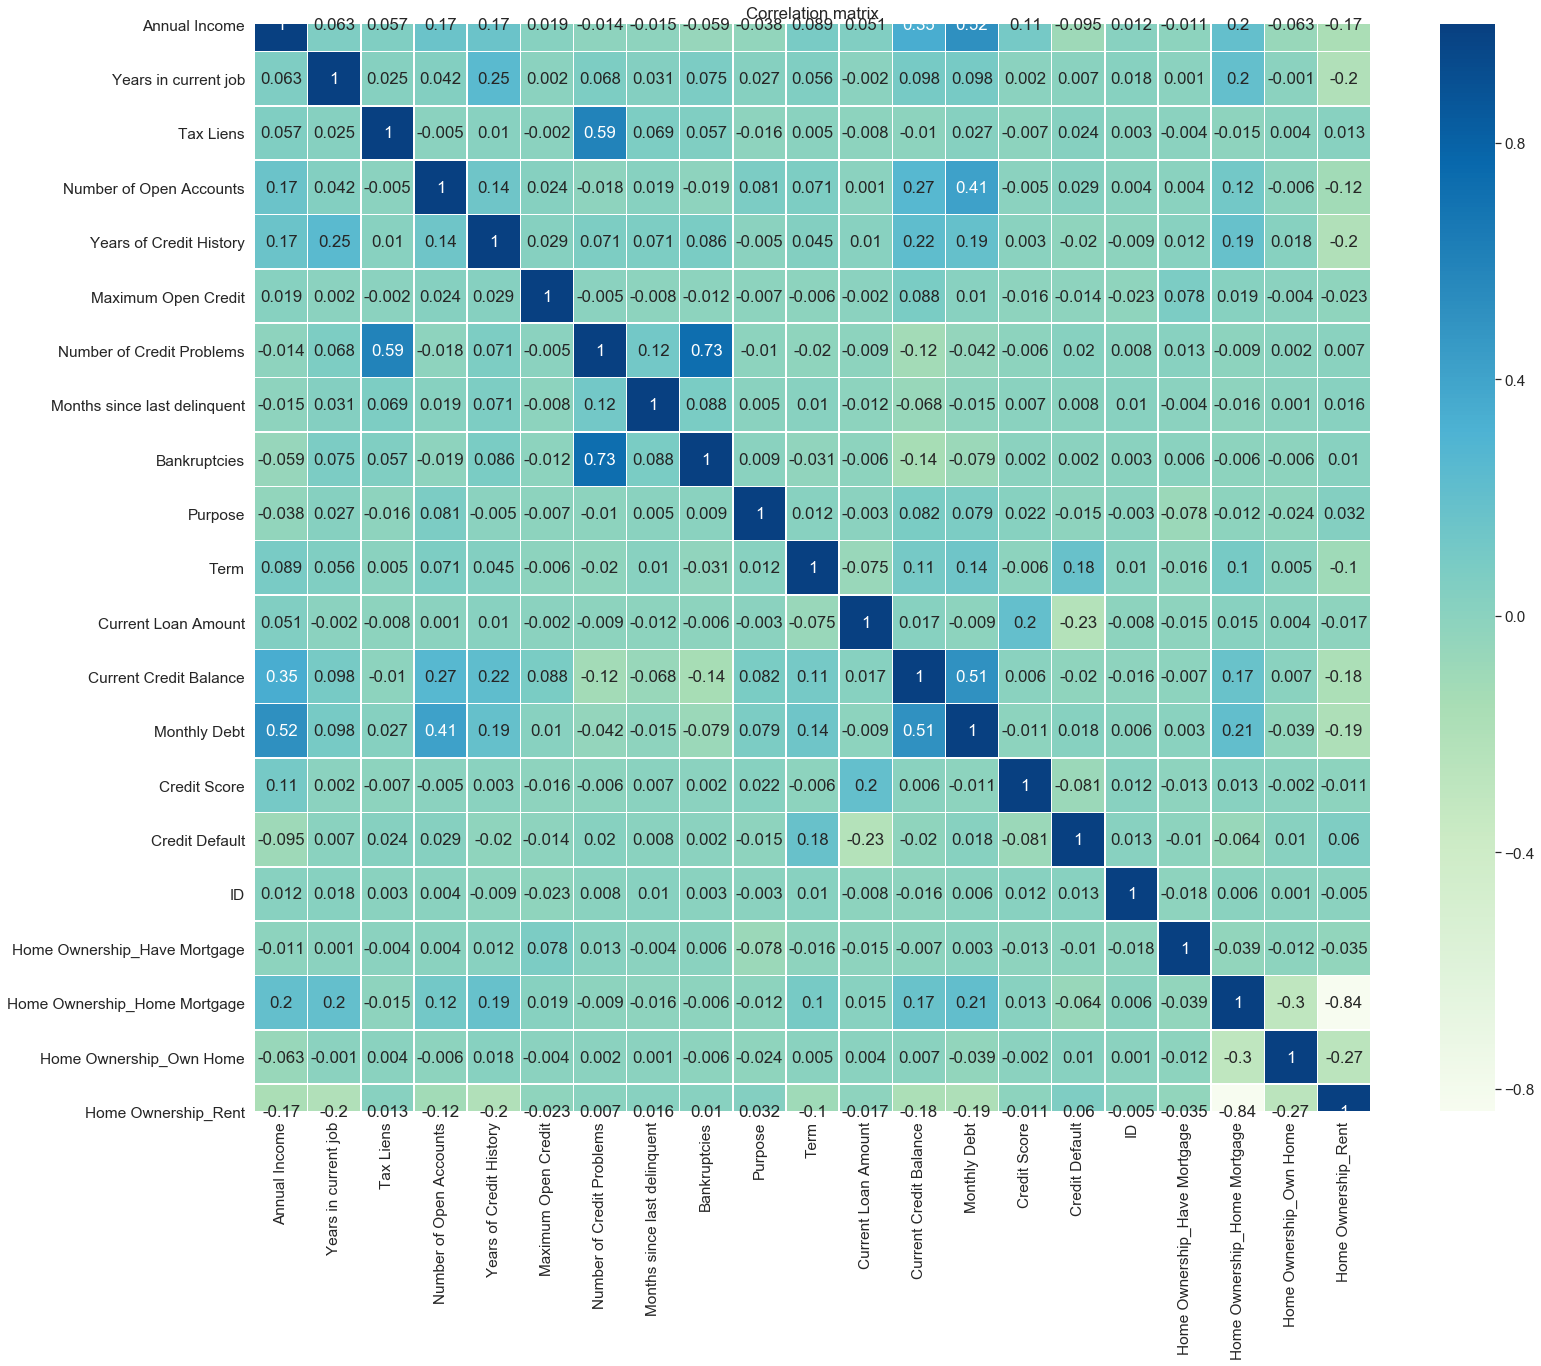

In [57]:
plt.figure(figsize = (25,20))

sns.set(font_scale=1.4)
sns.heatmap(df_train.corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

## Построение модели классификации

### Отбор признаков

In [58]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
Home Ownership                  2500 non-null object
Annual Income                   1987 non-null float64
Years in current job            2414 non-null object
Tax Liens                       2500 non-null float64
Number of Open Accounts         2500 non-null float64
Years of Credit History         2500 non-null float64
Maximum Open Credit             2500 non-null float64
Number of Credit Problems       2500 non-null float64
Months since last delinquent    1142 non-null float64
Bankruptcies                    2497 non-null float64
Purpose                         2500 non-null object
Term                            2500 non-null object
Current Loan Amount             2500 non-null float64
Current Credit Balance          2500 non-null float64
Monthly Debt                    2500 non-null float64
Credit Score                    1987 non-null float64
dtypes: float64(12), object(4)
me

In [59]:
df_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
Home Ownership                  7500 non-null object
Annual Income                   7500 non-null int64
Years in current job            7500 non-null int64
Tax Liens                       7500 non-null float64
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null float64
Months since last delinquent    7500 non-null int64
Bankruptcies                    7500 non-null int64
Purpose                         7500 non-null object
Term                            7500 non-null object
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Score                    7500 non-null int64
Credit Default                  7500 non-n

In [60]:
NUM_FEATURE_NAMES = df_base.select_dtypes(include=['float64', 'int64']).columns.tolist()[:-1]
NUM_FEATURE_NAMES

['Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']

In [61]:
CAT_FEATURE_NAMES = df_base.select_dtypes(include='object').columns.tolist()
CAT_FEATURE_NAMES

['Home Ownership', 'Purpose', 'Term']

In [62]:
SELECTED_FEATURE_NAMES = df_train.columns.drop([TARGET_NAME, 'ID']).tolist()
SELECTED_FEATURE_NAMES

['Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Home Ownership_Have Mortgage',
 'Home Ownership_Home Mortgage',
 'Home Ownership_Own Home',
 'Home Ownership_Rent']

In [63]:
SELECTED_FEATURE_NAMES_BASE = df_base.columns.drop([TARGET_NAME]).tolist()
SELECTED_FEATURE_NAMES_BASE

['Home Ownership',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']

### Приведение типов для модели CatBoost

In [64]:
for colname in CAT_FEATURE_NAMES:
    df_base[colname] = pd.Categorical(df_base[colname])
    
df_base[CAT_FEATURE_NAMES].dtypes

Home Ownership    category
Purpose           category
Term              category
dtype: object

In [65]:
df_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
Home Ownership                  7500 non-null category
Annual Income                   7500 non-null int64
Years in current job            7500 non-null int64
Tax Liens                       7500 non-null float64
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null float64
Months since last delinquent    7500 non-null int64
Bankruptcies                    7500 non-null int64
Purpose                         7500 non-null category
Term                            7500 non-null category
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Score                    7500 non-null int64
Credit Default                  7500

### Нормализация данных

In [66]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

df_norm = df_train.copy()
df_norm[SELECTED_FEATURE_NAMES] = scaler.fit_transform(df_norm[SELECTED_FEATURE_NAMES])

df = df_norm.copy()

**Сохранение модели для нормализации данных**

In [67]:
import pickle
with open(SCALER_FILE_PATH, 'wb') as file:
    pickle.dump(scaler, file)

### Разбиение на train и test для CatBoost

In [68]:
from sklearn.model_selection import train_test_split
X = df_base[SELECTED_FEATURE_NAMES_BASE]
y = df_base[TARGET_NAME]

X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)

### Разбиение на train и test

In [69]:
df_norm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 21 columns):
Annual Income                   7500 non-null float64
Years in current job            7500 non-null float64
Tax Liens                       7500 non-null float64
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null float64
Months since last delinquent    7500 non-null float64
Bankruptcies                    7500 non-null float64
Purpose                         7500 non-null float64
Term                            7500 non-null float64
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Score                    7500 non-null float64
Credit Default                  7500 non-null int64
ID                             

In [70]:
from sklearn.model_selection import train_test_split
X = df[SELECTED_FEATURE_NAMES]
y = df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)

### Балансировка целевой переменной

In [71]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.values.argmax()
    minor_class_name = target_counts.values.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [72]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

0    3771
1    2958
Name: Credit Default, dtype: int64

In [73]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

### Сохранение обучающего и тестового датасетов

In [74]:
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

In [75]:
df.to_csv(TRAIN_FULL_PATH, index=False, encoding='utf-8')
train.to_csv(TRAIN_PART_PATH, index=False, encoding='utf-8')
test.to_csv(TEST_PART_PATH, index=False, encoding='utf-8')

### Подбор моделей, получение бейзлана

### Построение и оценка базовых моделей

**Логистическая регрессия**

In [76]:
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

warnings.filterwarnings('ignore')

def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))
    
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.66      0.74      0.70      3771
           1       0.61      0.52      0.56      2958

    accuracy                           0.64      6729
   macro avg       0.64      0.63      0.63      6729
weighted avg       0.64      0.64      0.64      6729

TEST

              precision    recall  f1-score   support

           0       0.79      0.73      0.76      1616
           1       0.43      0.52      0.47       634

    accuracy                           0.67      2250
   macro avg       0.61      0.62      0.61      2250
weighted avg       0.69      0.67      0.68      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1179  437
1                307  327


**k ближайших соседей**

In [77]:
from sklearn.neighbors import KNeighborsClassifier
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

y_train_pred = model_knn.predict(X_train)
y_test_pred = model_knn.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.78      0.81      0.79      3771
           1       0.74      0.70      0.72      2958

    accuracy                           0.76      6729
   macro avg       0.76      0.76      0.76      6729
weighted avg       0.76      0.76      0.76      6729

TEST

              precision    recall  f1-score   support

           0       0.76      0.71      0.73      1616
           1       0.36      0.43      0.39       634

    accuracy                           0.63      2250
   macro avg       0.56      0.57      0.56      2250
weighted avg       0.65      0.63      0.64      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1143  473
1                363  271


**Бустинговые алгоритмы**

*XGBoost*

In [79]:
import xgboost as xgb
model_xgb = xgb.XGBClassifier(random_state=21)
model_xgb.fit(X_train, y_train)

y_train_pred = model_xgb.predict(X_train)
y_test_pred = model_xgb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      3771
           1       0.97      0.98      0.98      2958

    accuracy                           0.98      6729
   macro avg       0.98      0.98      0.98      6729
weighted avg       0.98      0.98      0.98      6729

TEST

              precision    recall  f1-score   support

           0       0.77      0.78      0.77      1616
           1       0.42      0.41      0.42       634

    accuracy                           0.67      2250
   macro avg       0.60      0.59      0.60      2250
weighted avg       0.67      0.67      0.67      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1255  361
1                372  262


*LightGBM*

In [81]:
import lightgbm as lgbm
model_lgbm = lgbm.LGBMClassifier(random_state=21)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.92      0.92      0.92      3771
           1       0.90      0.89      0.90      2958

    accuracy                           0.91      6729
   macro avg       0.91      0.91      0.91      6729
weighted avg       0.91      0.91      0.91      6729

TEST

              precision    recall  f1-score   support

           0       0.79      0.76      0.77      1616
           1       0.44      0.48      0.46       634

    accuracy                           0.68      2250
   macro avg       0.61      0.62      0.62      2250
weighted avg       0.69      0.68      0.69      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1232  384
1                332  302


*CatBoost*

In [83]:
import catboost as catb
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.90      0.90      0.90      3771
           1       0.87      0.87      0.87      2958

    accuracy                           0.89      6729
   macro avg       0.89      0.89      0.89      6729
weighted avg       0.89      0.89      0.89      6729

TEST

              precision    recall  f1-score   support

           0       0.79      0.76      0.77      1616
           1       0.44      0.48      0.46       634

    accuracy                           0.68      2250
   macro avg       0.61      0.62      0.62      2250
weighted avg       0.69      0.68      0.68      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1229  387
1                331  303


In [84]:
# CatBoost для первоначального датасета
model_catb = catb.CatBoostClassifier(class_weights=[1, 2.55], silent=True, random_state=21)
model_catb.fit(X_train_base, y_train_base, cat_features=X_train_base[CAT_FEATURE_NAMES])
y_train_pred = model_catb.predict(X_train_base)
y_test_pred = model_catb.predict(X_test_base)

get_classification_report(y_train_base, y_train_pred, y_test_base, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.95      0.78      0.86      3771
           1       0.62      0.88      0.73      1479

    accuracy                           0.81      5250
   macro avg       0.78      0.83      0.79      5250
weighted avg       0.85      0.81      0.82      5250

TEST

              precision    recall  f1-score   support

           0       0.81      0.66      0.73      1616
           1       0.42      0.61      0.50       634

    accuracy                           0.65      2250
   macro avg       0.61      0.64      0.61      2250
weighted avg       0.70      0.65      0.66      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1068  548
1                245  389


### Выбор наилучшей модели, настройка гиперпараметров

In [85]:
model_catb = catb.CatBoostClassifier(class_weights=[1, 2.55], silent=True, random_state=21)

**Подбор гиперпараметров**

In [86]:
params = {'n_estimators':[25, 50, 100, 300, 500, 700, 1000],
          'max_depth':[2, 3, 5, 7, 9, 11]}

In [87]:
from sklearn.model_selection import KFold
cv=KFold(n_splits=3, random_state=21, shuffle=True)

In [88]:
from sklearn.model_selection import RandomizedSearchCV

In [89]:
%%time

rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv)
rs.fit(X, y)

CPU times: user 3min 10s, sys: 8.72 s, total: 3min 19s
Wall time: 1min 22s


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=21, shuffle=True),
                   error_score='raise-deprecating',
                   estimator=<catboost.core.CatBoostClassifier object at 0x7f854ba26d10>,
                   iid='warn', n_iter=10, n_jobs=None,
                   param_distributions={'max_depth': [2, 3, 5, 7, 9, 11],
                                        'n_estimators': [25, 50, 100, 300, 500,
                                                         700, 1000]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring='f1', verbose=0)

In [90]:
rs.best_params_

{'n_estimators': 100, 'max_depth': 3}

In [91]:
rs.best_score_

0.5152801711889815

**Обучение и оценка финальной модели**

In [92]:
%%time

final_model = catb.CatBoostClassifier(class_weights=[1, 2.55], n_estimators=100, max_depth=3,
                                      silent=True, random_state=21)
final_model.fit(X_train_base, y_train_base, cat_features=X_train_base[CAT_FEATURE_NAMES])

y_train_pred = final_model.predict(X_train_base)
y_test_pred = final_model.predict(X_test_base)

get_classification_report(y_train_base, y_train_pred, y_test_base, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.87      0.63      0.73      3771
           1       0.44      0.75      0.56      1479

    accuracy                           0.66      5250
   macro avg       0.65      0.69      0.64      5250
weighted avg       0.75      0.66      0.68      5250

TEST

              precision    recall  f1-score   support

           0       0.84      0.57      0.68      1616
           1       0.40      0.73      0.52       634

    accuracy                           0.61      2250
   macro avg       0.62      0.65      0.60      2250
weighted avg       0.72      0.61      0.63      2250

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               917  699
1               169  465
CPU times: user 719 ms, sys: 124 ms, total: 842 ms
Wall time: 415 ms


### Проверка качества, борьба с переобучением

#### Подбор оптимального размера выборки для обучения

In [93]:
from sklearn.model_selection import learning_curve
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

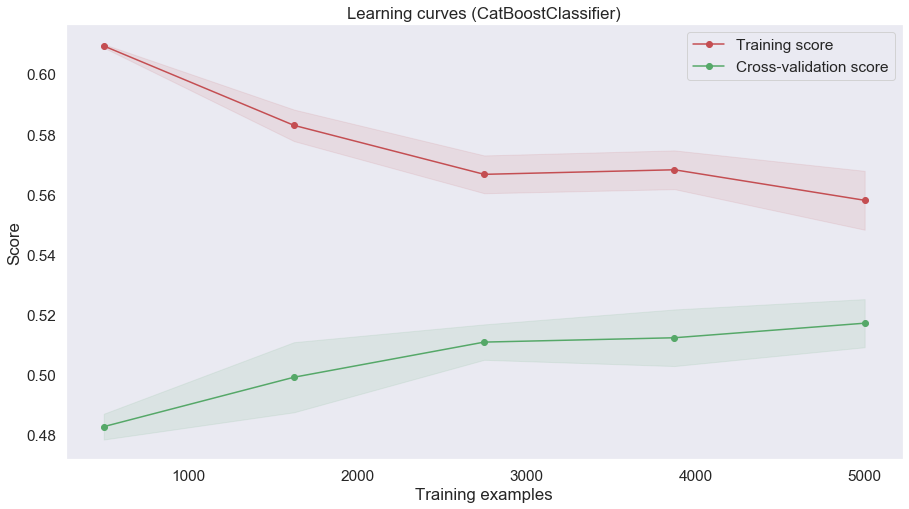

In [94]:
show_learning_curve_plot(final_model, X, y)

Выборка, которую мы использовали для обучения является достаточной.

### Важность признаков

In [95]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

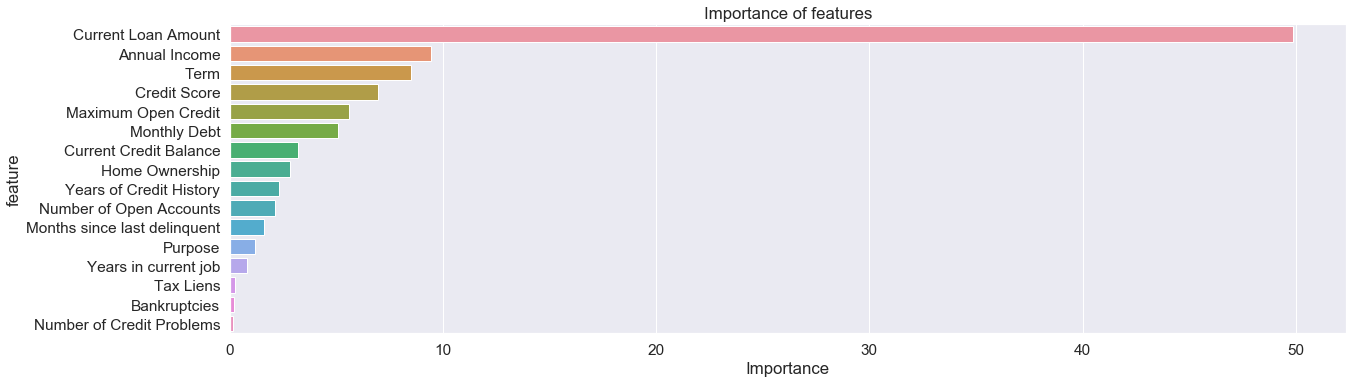

In [96]:
important_features_top = show_feature_importances(X_train_base.columns, final_model.feature_importances_, get_top=13)

In [97]:
important_features_top

['Current Loan Amount',
 'Annual Income',
 'Term',
 'Credit Score',
 'Maximum Open Credit',
 'Monthly Debt',
 'Current Credit Balance',
 'Home Ownership',
 'Years of Credit History',
 'Number of Open Accounts',
 'Months since last delinquent',
 'Purpose',
 'Years in current job']

### Обучение финальной модели на наиболее важных признаках

In [98]:
%%time

final_model_short = catb.CatBoostClassifier(class_weights=[1, 2.55], n_estimators=50, max_depth=3,
                                      silent=True, random_state=21)
final_model_short.fit(X_train_base[important_features_top], y_train_base, cat_features=X_train_base[CAT_FEATURE_NAMES])

y_train_pred = final_model_short.predict(X_train_base[important_features_top])
y_test_pred = final_model_short.predict(X_test_base[important_features_top])

get_classification_report(y_train_base, y_train_pred, y_test_base, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.86      0.63      0.73      3771
           1       0.44      0.75      0.55      1479

    accuracy                           0.66      5250
   macro avg       0.65      0.69      0.64      5250
weighted avg       0.74      0.66      0.68      5250

TEST

              precision    recall  f1-score   support

           0       0.83      0.57      0.67      1616
           1       0.39      0.71      0.50       634

    accuracy                           0.61      2250
   macro avg       0.61      0.64      0.59      2250
weighted avg       0.71      0.61      0.63      2250

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               918  698
1               186  448
CPU times: user 379 ms, sys: 39 ms, total: 418 ms
Wall time: 197 ms


Лучшей оказалась модель для полного датасета

### Сохранение финальной модели

In [99]:
MODEL_FILE_PATH = './model.pkl'
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(final_model, file)

## Прогнозирование на тестовом датасете

In [100]:
df_test.loc[df_test['Annual Income'].isnull(), 'Annual Income'] = df_test['Annual Income'].median()
df_test.loc[df_test['Months since last delinquent'].isnull(), 'Months since last delinquent'] = df_test['Months since last delinquent'].mode()[0]
df_test.loc[df_test['Credit Score'] / 1000 > 1, 'Credit Score'] = df_test['Credit Score'] / 10
df_test.loc[df_test['Credit Score'].isnull(), 'Credit Score'] = 0
df_test.loc[df_test['Bankruptcies'].isnull(), 'Bankruptcies'] = df_test['Bankruptcies'].mode()[0]
replacement(df_test)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
Home Ownership                  2500 non-null object
Annual Income                   2500 non-null float64
Years in current job            2500 non-null int64
Tax Liens                       2500 non-null float64
Number of Open Accounts         2500 non-null float64
Years of Credit History         2500 non-null float64
Maximum Open Credit             2500 non-null float64
Number of Credit Problems       2500 non-null float64
Months since last delinquent    2500 non-null float64
Bankruptcies                    2500 non-null float64
Purpose                         2500 non-null object
Term                            2500 non-null object
Current Loan Amount             2500 non-null float64
Current Credit Balance          2500 non-null float64
Monthly Debt                    2500 non-null float64
Credit Score                    2500 non-null float64
dtypes: float64(12), int64(1), obj

In [101]:
%%time

X_test = df_test

y_pred = final_model.predict(X_test)
y_pred = pd.DataFrame(y_pred, columns=['Credit Default'])

CPU times: user 9.13 ms, sys: 2.54 ms, total: 11.7 ms
Wall time: 11 ms


In [102]:
y_pred.head()

,Credit Default
0,0
1,1
2,0
3,0
4,0


In [103]:
y_pred['Credit Default'].value_counts()

0    1275
1    1225
Name: Credit Default, dtype: int64

In [104]:
import csv
y_pred.to_csv(PROBA_DATASET_PATH, index=False, encoding='utf-8')